<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/VivekP/04-ReLUInvestigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Rectified Linear Unit (ReLU) Activation Function

In this document, we investigate the rectified linear unit (ReLU) activation function in using neural networks to classify brain tumours.

**Note**: It is recommended to view the document in VS Code as the images are properly centered there.

# Table of Contents
- [1. Requirements](#1-requirements)
- [2. Neural Networks](#2-neural-network)
- [3. Training using Backpropagation](#3-training-using-backpropagation)
- [4. The Rectified Linear Unit](#4-the-rectified-linear-unit)
- [5. Data Loading](#5-data-loading)
- [6. Data Augmentation](#6-data-augmentation)
- [7. Investigations](#7-investigations)
- [8. Scaling](#8-scaling)
- [9. Conclusion](#9-conclusion)
- [10. References](#10-references)

# 1. Requirements

We load the required packages below.

In [2]:
import subprocess
import sys

# List of packages to check/install
required_packages = [
    "numpy",
    "matplotlib",
    "tensorflow",
    "tqdm",
    "opencv-python",  # Correct package name for OpenCV
    "imutils",
    "kagglehub",
]

# Install a package using pip
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Loop through each package and ensure it's installed
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"{package} is not installed. Installing...")
        install_package(package)

import os
import json
import time
import hashlib
import random
from pathlib import Path  # To work with paths

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from tqdm import tqdm
import cv2
import imutils

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import (
    ExponentialDecay,
    PiecewiseConstantDecay,
    PolynomialDecay,
    CosineDecay,
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    ReduceLROnPlateau,
    EarlyStopping,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.activations import swish

import kagglehub


opencv-python is not installed. Installing...


# 2. Neural Network

A neural network (NN) is a machine learning model inspired by how the *human brain* works (see [16, 20] for a detailed history, including the work of McCullogh and Pitts, the development of the perceptron, and more).

## 2.1. Basics

We explain the basics of neural networks, using information from [17, 18]. A neural network (NN) is composed of layers of interconnected nodes called **neurons**. These neurons are organized in three main layers:

- **Input layer**: This is where data enters the network. Each input feature (e.g., pixels of an image or values in a dataset) corresponds to one neuron in this layer.
- **Hidden layers**: These intermediate layers perform the actual processing. Each neuron in a hidden layer receives inputs from the previous layer, applies a mathematical operation (known as an **activation function**), and passes the result to the next layer.
- **Output layer**: This layer produces the network's final output or prediction, such as a classification label.

Collectively, this is called the **architecture** of the NN. This is shown in the figure below.

<div align="center">
    <figure>
        <img src="https://miro.medium.com/v2/resize:fit:1400/1*L1bH8PUeLf67Aat-h5phpw.png" alt="Figure taken from Medium Article - accessed 10/11/2024." title="Beautiful Sunset">
        <figcaption>
            Figure showing the architecture of a neural network. Figure taken from 
            <a href="https://miro.medium.com/v2/resize:fit:1400/1*L1bH8PUeLf67Aat-h5phpw.png" target="_blank" rel="noopener noreferrer">Medium Article</a> - accessed 10/11/2024 09:00.
        </figcaption>
    </figure>
</div>




We explain how this works mathematically in Section 2.2 of `VivekP/04-ReLUInvestigation.ipynb`. "For our desired task of image classification, we will use a special type of neural network called a convolutional neural network (CNN). In the next section, we provide a condensed explanation of how a CNN works. More details, including references, are given in Section 2.3 of `VivekP/04-ReLUInvestigation.ipynb`.

# 2.3. Convolutional Neural Network
Convolutional Neural Networks (CNNs) are specialized for image tasks by using small filters (kernels) that slide over the image, detecting features like edges, textures, and shapes. This process, called convolution, generates feature maps, which highlight areas where patterns are detected [19, 25]. This mimics the way biological vision systems, as studied by Hubel and Wiesel, respond to specific regions of the visual field [19].

Key Concepts:
- **Input and Convolution**: Instead of fully connecting each input to neurons, CNNs use kernels (e.g., 3x3 matrices) that scan the image in small regions. The resulting feature map represents where patterns occur [19]. An example is shown in the figure below.

<div align="center">
<figure style="text-align: center;">
  <img src="https://i.sstatic.net/pLlwx.png" alt="Example of feature maps" title="Feature Maps Example">
  <figcaption>
    Figure showing an example of feature maps. Accessed 10/11/2024 09:00 from 
    <a href="https://i.sstatic.net/pLlwx.png" target="_blank" rel="noopener noreferrer">here</a>. 
    Here we use 2 filters and get 2 feature maps.
  </figcaption>
</figure>
</div>

- **Padding, Kernel Size, and Stride**:
    - Padding: Zero-padding is used to preserve spatial dimensions, especially at the image borders [27].
    - Kernel Size: Smaller kernels (3x3) capture fine details, while larger ones (7x7) capture broader features, impacting the depth and complexity of the network.
    - Stride: The stride controls how far the filter moves at each step. A smaller stride extracts more detail, while a larger stride reduces computation but captures less detail.
- **Feature Detection and Pooling**: Filters detect specific patterns, creating feature maps that highlight object regions. Pooling layers then reduce feature map sizes, with max pooling selecting the highest values in each region to summarize strong features [26].
- **Stacking Layers**: CNNs stack multiple convolutional and pooling layers to capture increasingly complex patterns. Early layers detect simple features (e.g., edges), while deeper layers combine these to identify complex objects.
- **Fully Connected Layers**: After convolution and pooling, feature maps are flattened into a 1D vector and passed through fully connected layers to make predictions or classifications.

This brief overview synthesizes key concepts from [19, 25, 26, 27], demonstrating how CNNs efficiently process and analyze images. A picture summarizing the above information is shown below.

<div align="center">
<figure style="text-align: center;">
    <img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2024/08/183560-qcmbdpukpdviccdd-66c7065d8f850.webp" alt="Figure from Analytics Vidhya - accessed 10/11/2024.">
    <figcaption>Figure from <a href="https://cdn.analyticsvidhya.com/wp-content/uploads/2024/08/183560-qcmbdpukpdviccdd-66c7065d8f850.webp">Analytics Vidhya</a> - accessed 10/11/2024.</figcaption>
</figure>
</div>
In this overview, we’ve touched on the key aspects of how CNNs work. However, there is much more to explore in the literature, especially when it comes to understanding the deeper mechanics of CNNs, such as how they "see depth" in images. For a more comprehensive look at this topic, including insights from studies like [40], we invite the reader to delve into Section 2.3 of `04-ReLUInvestigation.ipynb`, where we explore these concepts in greater detail and provide further references for deeper understanding.

We highlight some of the advantages and disadvantages of CNNs (synthesizing information from [29, 30]) which make them especially good for image processing. We provide a brief summary below:
- Automatic feature learning: CNNs can automatically learn relevant features from raw input data, which eliminates the need for manual feature engineering. This is particularly helpful here as we are not medical experts and do not know what features to extract from the images.
- High accuracy: CNNs can achieve state-of-the-art performance in various image and video recognition tasks. This motivates us to consider a CNN instead of other classifiers like logistic regression.
- Robustness: Using data augmentation (see later section), CNNs can have high performance even if the images have different qualitative features, such as being taken with different brightness, contrast or angles.

Despite their many advantages, CNNs also have some disadvantages. The one we felt the most was the high computational requirement -- CNNs required significant computational resources, including the use of GPUs (graphics processing units) (see appendix for an explanation on parallelism with GPUs -- including why they are suited to fitting CNNs) or TPUs (tensor processing units) to train and deploy. It can also be prone to overfitting and can fail with adversarial examples when some noise is added to an image [29]. However, they remain a powerful tool.

We next briefly state how a CNN is trained, with reference to backpropagation and gradient descent.

# 3. Training Using Backpropagation  

## 3.1. Gradient Descent  
Neural networks learn by adjusting weights and biases using backpropagation and gradient descent. Errors propagate backward to update weights, reducing the *loss function*, which measures the gap between predicted and actual outputs. The learning rate controls the step size along the gradient, and repeated iterations over the dataset, called *epochs*, improve accuracy. Gradient descent typically computes gradients using all data points, but this becomes computationally expensive for large datasets.  

<div align="center">
<figure style="text-align: center;">
    <img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2024/09/631731_P7z2BKhd0R-9uyn9ThDasA.webp" alt="Figure taken from Analytics Vidhya - accessed 10/11/2024.">
    <figcaption>Figure showing the process of gradient descent. Figure taken from <a href="https://cdn.analyticsvidhya.com/wp-content/uploads/2024/09/631731_P7z2BKhd0R-9uyn9ThDasA.webp">Analytics Vidhya</a> - accessed 10/11/2024.</figcaption>
</figure>
</div>


To remedy this, we use stochastic gradient descent.

## 3.2. Stochastic Gradient Descent (SGD)  
Stochastic Gradient Descent (SGD), introduced by Robbins and Monro in "[A Stochastic Approximation Method](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-22/issue-3/A-Stochastic-Approximation-Method/10.1214/aoms/1177729586.full) [31]," randomly selects data subsets (batches) to approximate gradients. This reduces computational costs by leveraging vectorization libraries, making it ideal for large datasets [32].  

An *epoch* involves a full dataset pass, with smaller batches requiring more iterations per epoch. For example, 1,000 samples with a batch size of 500 need two iterations per epoch [32]. Although loss functions are often non-convex, SGD converges to a local minimum (or global minimum for convex problems) under certain conditions [31]. Its efficiency and reliability have made SGD a standard in deep learning.  

<div align="center">
<figure style="text-align: center;">
    <img src="https://i.makeagif.com/media/12-08-2023/g4oDOp.gif" alt="GIF demonstrating Stochastic Gradient Descent" style="width: 80%; max-width: 800px;">
    <figcaption>Figure showing the process of backpropagation. Figure taken from <a href="makeagif.com/gif/backpropagation-on-neural-networks-g4oDOp">makeagif.com</a> - accessed 11/11/2024.</figcaption>
</figure>
</div>

In Section 3 of `04-ReLUInvestigation.ipynb`, we provide much more detail. With these foundational principles in place, we now explore the role of the ReLU activation function in CNNs.


# 4. The Rectified Linear Unit

In this section, we describe the ReLU. We provide a condensed account. More detail is available in Section 4 of `04-ReLUInvestigation.ipynb`.

## 4.1. Definition
The rectified linear unit (ReLU) is defined as:
$$f(x) = \max\{0, x\}.$$
It is a widely used activation function in neural networks. The plot below illustrates the ReLU function and its derivative.

<figure style="text-align: center;">
    <img src="images/ReLU.png" alt="ReLU activation function visualization" style="width: 80%; max-width: 800px;">
    <figcaption>Figure showing the ReLU activation function, a widely used non-linear activation in neural networks. Figure taken from <code>04-ReLUInvestigation.ipynb</code>.</figcaption>
</figure>

To understand why ReLU is important, we explore its historical background (Section 4.2), features and advantages (Section 4.3), and some of its limitations (Section 4.4). This will provide the context for us to extract insights from our empirical investigations in Section 5.

## 4.2. History

The ReLU was first used by Alston Householder in 1941 as a mathematical abstraction of biological neural networks (those in the human nervous system rather than the deep learning method) [11]. It was introduced by Kunihiko Fukushima in 1969 to extract visual features using a neural network [12]. This seminal paper gives an insight into how the biological nervous system has led to the idea of a neural network. In particular, the ReLU works similar to a biological neuron, which either fires a signal or not. This matches the form of the ReLU, which has a positive signal for $x > 0$ and no signal otherwise.

As of 2017, ReLU is the most popular activation function for deep neural networks [7]. ReLUs are used widely, with applications in computer vision (the field concerned with the analysis and processing of images) [8], speech recognition [9], biology and neuroscience [10]. It is therefore an apt choice for our problem of classifying brain tumours.


## 4.3. Features of ReLU
ReLU's widespread use stems from several advantages:

- **Non-linearity**: ReLU introduces non-linearity to neural networks, which is essential because linear functions are closed under composition, reducing the network's ability to model complex data.
- **Sparse activation**: In a typical network, approximately 50% of the hidden units are activated, which leads to faster and more efficient computation [15].
- **Idempotence under composition**: Unlike sigmoidal functions, ReLU does not saturate in both directions when repeatedly composed, thus reducing the likelihood of vanishing gradients, especially in deep networks.
    <div align="center">
    <figure style="text-align: center;">
        <img src="images/activation-self.png" alt="Activation Functions: Effect of Self-Composition" style="width: 80%; max-width: 800px;">
        <figcaption>Figure showing the effect of self-composition on activation functions. Image taken from <code>04-ReLUInvestigation.ipynb</code>. We can see that with more composition, the ReLU stays the same, while the swish and hyperbolic tangent become flatter.</figcaption>
    </figure>
    </div>

- **Efficient computation**: ReLU requires only simple comparisons and additions, making it computationally inexpensive. The gradient is either 0 or 1, which is easy to compute, contributing to faster training [30].
- **Scale invariance**: ReLU is scale-invariant, i.e., $$f(ax) = af(x)$$ for any constant $a \geq 0$. This property can be leveraged to improve properties of some optimization techniques like stochastic gradient descent [29].
- **Biological plausibility**: The behavior of ReLU—where neurons are either active (outputting a positive signal) or inactive (outputting zero)—mimics biological neurons, adding an intuitive appeal to its use.

## 4.4. Disadvantages of ReLU
Despite its strengths, ReLU has some limitations:

- **Non-differentiability at zero**: The derivative at $x = 0$ is undefined, which can be problematic in some contexts [14].
- **Not zero-centered**: Since ReLU outputs only non-negative values, it can lead to biased gradient updates during training. This may slow down the learning process, but techniques like batch normalization can mitigate this effect [14].
- **Unbounded outputs**: ReLU can produce very large outputs for large positive inputs, potentially causing numerical instability. This can be managed using methods like gradient clipping or $L^2$ regularization [30].
- **"Dying ReLU" problem**: If a ReLU neuron’s output is zero for most inputs, it can become inactive, effectively “dying.” This is a form of the vanishing gradient problem. Variants like Leaky ReLU and Swish have been developed to address this issue [14, 35].

In summary, ReLU is a powerful and efficient activation function, but like all methods, it has its limitations. 

In the next section, we will explore how ReLU's performance in deep neural networks is impacted by these factors, using brain tumor data from Kaggle [1].


# 5. Data Loading

The data contains around 7000 images of brain MRI scans (see EDA file for detailed description and explanation). We will be repeating the preprocessing in the EDA file. The reader is invited to consult the EDA file for descriptions on the image processing techniques used below, such as dilation and erosion.

In [4]:
# Code taken from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/discussion/482896
## Additional comments and explanations in VivekP/03-EDA.ipynb

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

# Convert path to a Path object
path = Path(path)

# Define your project directory and labels based on your dataset structure
PROJECT_DIR = path
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']  # Adjust these labels based on your dataset's folder names

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


# Convert 'path' to Path object (already done above)
train_dir = path / "Training"
test_dir = path / "Testing"

if __name__ == "__main__":
    training = train_dir
    testing = test_dir

    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    IMG_SIZE = 256

    for dir in training_dir:
        save_path = Path('cleaned/Training') / dir  # Using pathlib's '/' operator
        path = training / dir  # Using pathlib's '/' operator
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))  # Convert Path to string for OpenCV
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)  # Convert Path to string for OpenCV

    for dir in testing_dir:
        save_path = Path('cleaned/Testing') / dir
        path = testing / dir
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)


Resuming download from 0 bytes (155791278 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/masoudnickparvar/brain-tumor-mri-dataset?dataset_version_number=1 (0/155791278) bytes left.


100%|██████████| 149M/149M [04:35<00:00, 566kB/s] 

Extracting files...


Path to dataset files: C:\Users\megar\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


# 6. Data Augmentation

## 6.1. Purpose of Data Augmentation
Data augmentation helps address the issue of limited data by generating artificial variations of existing data, improving the neural network's ability to generalize during testing and deployment [1, 3, 4, 5, 6]. This technique, introduced in the 1990s alongside CNNs, involves applying transformations like rotations, flips, and changes in brightness to create diverse training examples. It ensures better generalization by increasing data diversity (e.g., varying positions, angles, and lighting conditions) without needing more raw data [8]. We provide some more detail in Section 6.1 of `04-ReLUInvestigation.ipynb`.

## 6.2. Performing Data Augmentation
To implement data augmentation, we’ll use Keras' `ImageDataGenerator` [3] to rescale pixel values and apply geometric transformations (e.g., rotations, flips, zooms).


In [4]:
# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',  # Fill any missing pixels using the nearest pixel
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness between 0.5 and 1.5 times the original
    channel_shift_range=20.0,  # Randomly shift RGB channels (intensity)
    validation_split=0.2  # Use 20% of the training data for validation
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load images from directories using ImageDataGenerator
print('Training Data: ')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset = 'training',
    shuffle=True
)
print('Validation Data: ')
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset = 'validation',
    shuffle=True
)
print('Testing Data: ')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test data
)


Training Data: 
Found 4571 images belonging to 4 classes.
Validation Data: 
Found 1141 images belonging to 4 classes.
Testing Data: 
Found 1311 images belonging to 4 classes.


We explain the key arguments in `ImageDataGenerator` using the documentation [3] (see more detail in `04-ReLUInvestigation.ipynb`):

1. **Rotation**: Randomly rotates images to help the model recognize features at different angles, useful for slightly tilted brain scans.
2. **Width and Height Shift**: Randomly shifts images horizontally and vertically, allowing the model to detect features regardless of position (e.g., off-center tumors).
3. **Shear**: Applies a shearing transformation to simulate distortions, helping the model recognize deformed or angled objects.
4. **Zoom**: Randomly zooms in by up to 20%, helping the model learn from both close-up and wide perspectives of features, useful for tumors of different sizes.
5. **Horizontal Flip**: Flips images horizontally with a 50% chance, aiding in invariance to left-right orientation.
6. **Fill Mode (`'nearest'`)**: Fills pixels from transformations with the nearest pixel, preserving image continuity at edges.
7. **Brightness Range**: Adjusts image brightness randomly, simulating different lighting conditions to improve model robustness.
8. **Channel Shift Range**: Adjusts contrast by shifting pixel values, either darkening or lightening the image (useful for grayscale images).

A sample of augmented images is shown below.


Selected random image: cleaned/Training/notumor/Tr-no_0672.jpg


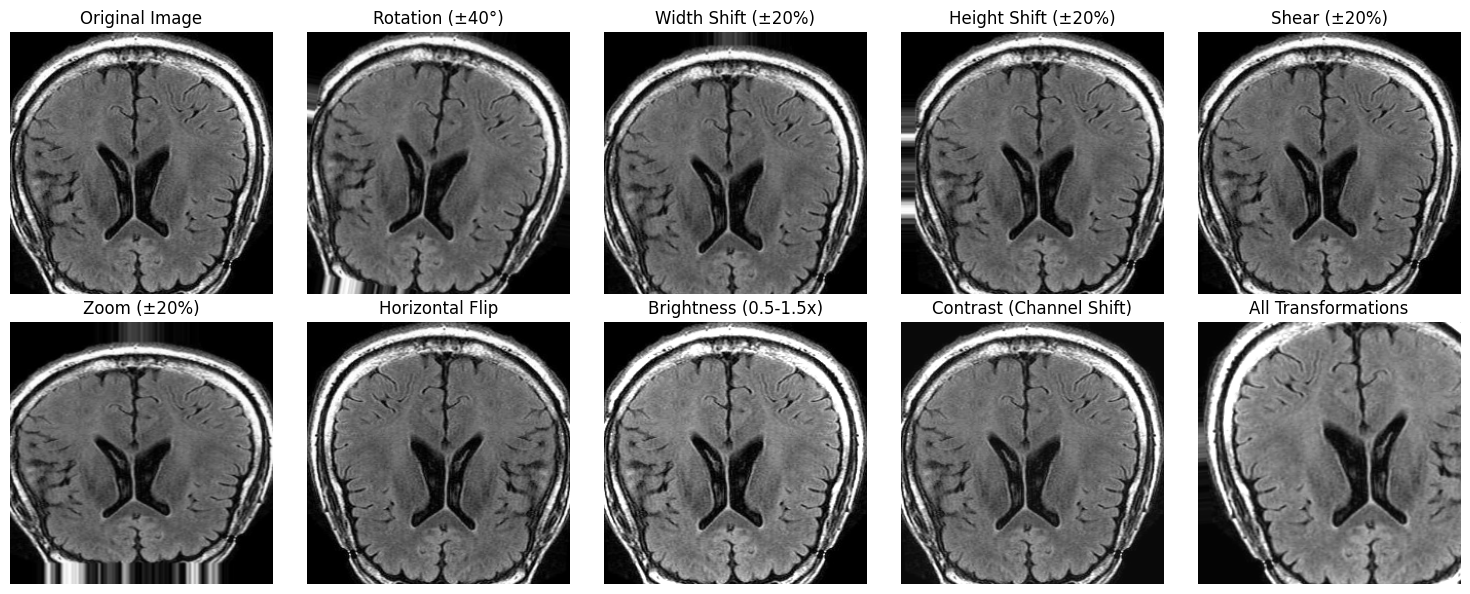

In [ ]:
# Set a fixed seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

# Define the train directory
train_dir = Path('cleaned/Training')

# Get all label subdirectories (e.g., pituitary, notumor, etc.)
label_dirs = [d for d in train_dir.iterdir() if d.is_dir()]

# Choose a random label directory and a random image within it
# Uncomment the following lines to randomly select an image
# random_label_dir = random.choice(label_dirs)
# image_files = list(random_label_dir.glob('*.jpg'))  # Assuming images are in .jpg format
# random_image_path = random.choice(image_files)
random_image_path = "cleaned/Training/notumor/Tr-no_0672.jpg"  # Manually specify an image path

# Load the chosen random image
img = load_img(random_image_path)  # Load the image
img_array = img_to_array(img)      # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension for generator

# Print selected image path
print(f"Selected random image: {random_image_path}")

# Function to display augmented images in rows, starting with the original image
def display_augmented_images_with_original(datagen_dict, img_array, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()  # Flatten to iterate easily

    # Display the original image in the first slot
    axes[0].imshow(img_array[0].astype('uint8'), cmap='gray')  # Assuming grayscale images
    axes[0].axis('off')
    axes[0].set_title("Original Image")

    # Display each augmentation in the remaining slots
    for ax, (title, datagen) in zip(axes[1:], datagen_dict.items()):
        augmented_images = datagen.flow(img_array, batch_size=1, seed=seed)
        aug_img = next(augmented_images)[0].astype('uint8')  # Generate one augmented image
        ax.imshow(aug_img, cmap='gray')  # Assuming grayscale images
        ax.axis('off')
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# Define individual augmentations as datagen instances with titles (excluding Fill Mode only)
datagen_dict = {
    "Rotation (±40°)": ImageDataGenerator(rotation_range=40),
    "Width Shift (±20%)": ImageDataGenerator(width_shift_range=0.2),
    "Height Shift (±20%)": ImageDataGenerator(height_shift_range=0.2),
    "Shear (±20%)": ImageDataGenerator(shear_range=0.2),
    "Zoom (±20%)": ImageDataGenerator(zoom_range=0.2),
    "Horizontal Flip": ImageDataGenerator(horizontal_flip=True),
    "Brightness (0.5-1.5x)": ImageDataGenerator(brightness_range=(0.5, 1.5)),
    "Contrast (Channel Shift)": ImageDataGenerator(channel_shift_range=20.0),
    "All Transformations": ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=(0.5, 1.5),
        channel_shift_range=20.0
    )
}

# Display the original image followed by augmentations in a 2x5 grid
display_augmented_images_with_original(datagen_dict, img_array)


We can see that the code indeed produces the augmentations that they claim to do. Note that the values next to the transformation only indicate the range of the transformations performed. To clarify, "Rotation ($\pm$ 40 degrees)" means that a rotation of up to 40 degrees clockwise or anticlockwise is performed. We emphasize that this is not necessarily a rotation of exactly 40 degrees.

We can see distortions in the rotation and zoom images. This highlights the importance of using the `fill_mode` parameter in `keras`, which will prevent such things from happening. We can see what `fill_mode` does for use in the last image which used a random combination of transformations.

Overall, we can conclude from this image that `ImageDataGenerator` works reasonably, and we work with this without qualms for the rest of the text.

# 7. Investigations

Convolutional Neural Networks (CNNs) are powerful models, especially for image-based tasks. However, as noted by [38], "our theoretical understanding of their properties is still partial at best." From earlier sections, we have identified several factors that influence CNN performance, including:

- **Network architecture**: Depth and width of the network. 
- **Types of layers**:
  - **Convolutional layers**: Key hyperparameters include:
    - Filter size
    - Number of filters
    - Stride (filter step size)
    - Padding (preserving spatial dimensions)
  - **Pooling layers**
- **Training parameters**:
  - **Learning rate**: Determines the step size in gradient descent.
  - **Epochs**: Number of full passes through the dataset.
  - **Batch size**: Affects the time and stability of training.

Understanding the impact of each of these factors is crucial for optimizing CNN performance. In the next section, we describe the setup and goals for investigating these parameters.

## 7.1 Setup and Goals

We use the same train-test-validate split throughout, using the data augmentation techniques described earlier. We seek to understand the impact of the parameters on performance, and so we do not attempt a sequential optimization of parameters here. Throughout, we will make use of a GPU from [Google Colab](https://colab.research.google.com/) (see `VivekP/05-GPUParallelism.ipynb` for details on parallelism with GPUs).  We will investigate the following:
- depth;
- bach size;
- learning rate;
- $L^1$ and $L^2$ regularisation.

## 7.2 Depth and Width

The effects of width on neural network performance have been widely discussed in studies [37-42]. These studies emphasize the importance of depth and width in designing neural networks and understanding their interaction is crucial for improving performance.

A key question in the literature is how depth (related to function compositions) and width (related to function addition) affect a model's learning capabilities. Adding depth creates a highly oscillatory function, while increasing width leads to fewer oscillations. This distinction is explored in [Section 3.3, 37], with a visualization available in a [Desmos](https://www.desmos.com/calculator/6o4ab3bun6) widget [43] we prepared. Empirical evidence indicates that depth can help capture more complex patterns, but the formal understanding of this interaction is still limited [37, 39]. It is well-known that large depth-2 networks can approximate any continuous function [39, 44], but our investigation contributes to understanding how depth and width interact in CNNs.

This investigation connects to the wider literature on neural networks, including feedforward [39, 44], graph [46], and recurrent networks [45], as well as more recent work on Transformers and Neural GPUs [39, 46]. Additionally, research on depth in neural networks relates to Boolean circuits and "depth hierarchy theorems" [37], which prove the inapproximability of certain functions by shallow circuits unless they have exponentially many nodes.

### 7.2.1 Shallow Depths

We began by testing depths from 1 to 5 convolutional layers, systematically increasing the number of filters as depth increased to assess its impact on model performance. Initially, we used max-pooling after each convolutional layer to reduce the size of feature maps, but this caused problems as the feature maps became too small with deeper layers, preventing the model from fitting with 5 layers.

We considered alternatives like pooling less frequently, similar to VGG-like architectures (Figure 1), which maintain higher spatial resolution. However, due to computational constraints, we opted to maintain pooling after each layer, which we believed was fairer for all layers.

<div align="center">

<figure style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*few2VVEzn6DMVX-kofszhA.png" 
         alt="VGG-like architecture" 
         style="width:100%; max-width:700px;">
    <figcaption>
        Figure showing VGG-like architectures. Taken from 
        <a href="https://medium.com/" target="_blank" style="color: gray; text-decoration: underline;">Medium article</a>, accessed 20/11/2024 14:00.
    </figcaption>
</figure>
</div>


The solution came when we switched from "valid" padding to "same" padding. "Valid" padding shrinks the feature map as it moves through layers, whereas "same" padding keeps the size constant, preserving resolution and improving training without increasing computational demands. We provide the code used in our investigation below. For brevity, we have removed the plotting code but kept the plots which were output (the reader may look at `VivekP/model_saved` and `VivekP/04-ReLUInvestigation.ipynb` for more details on the plotting).


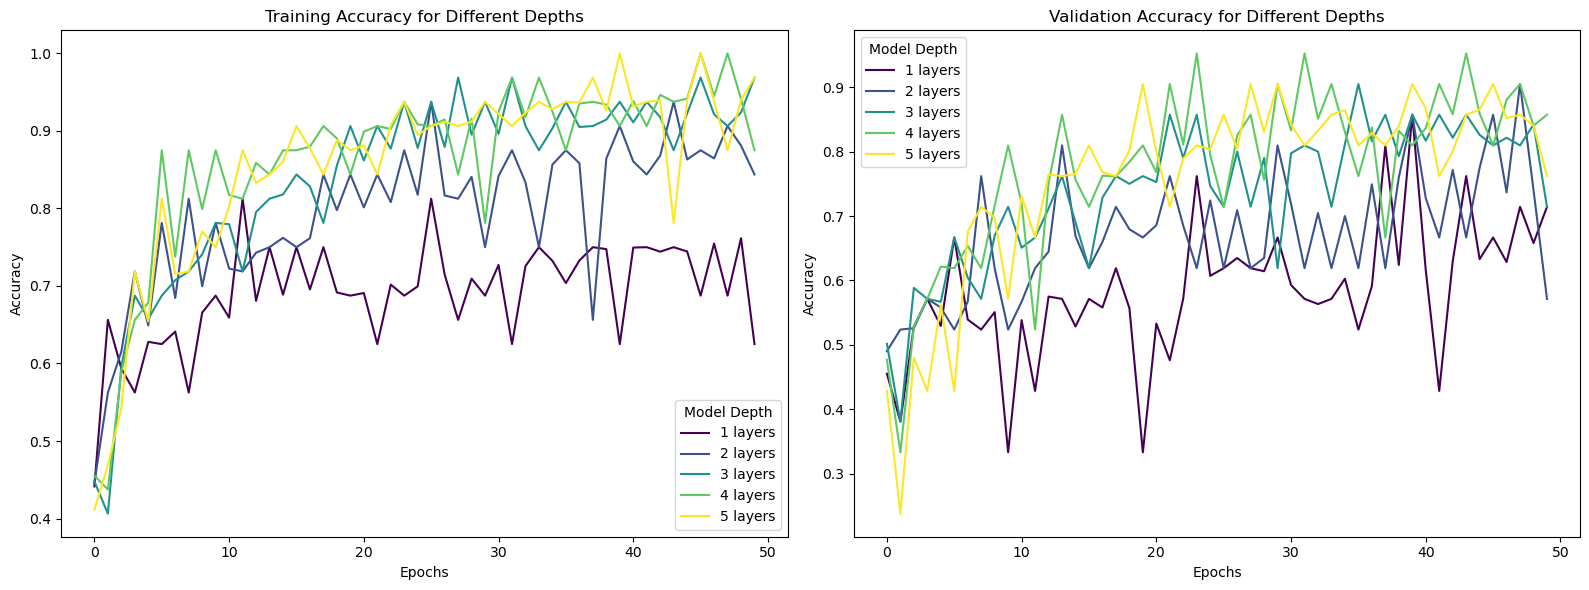

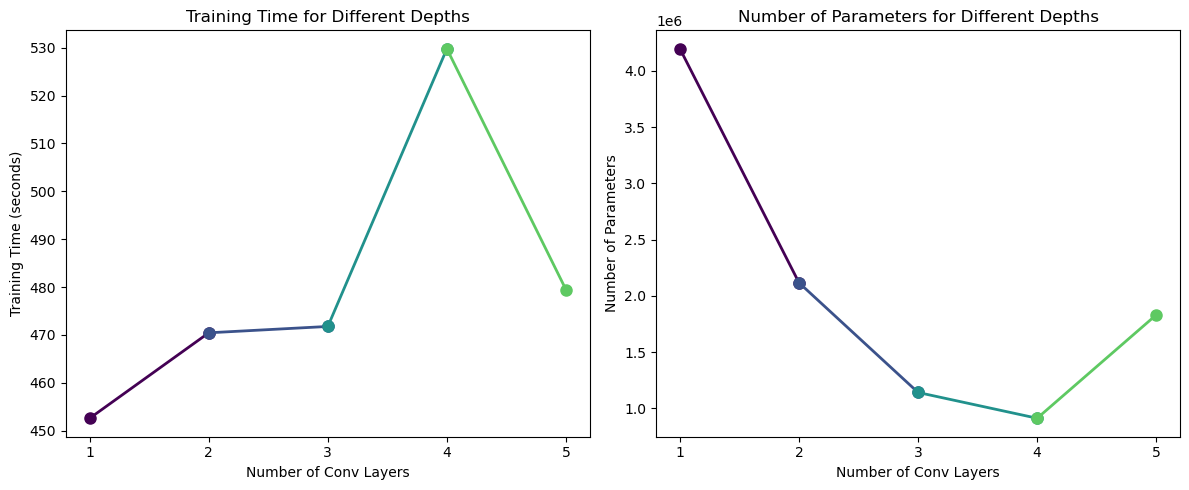

In [ ]:
# Parameters
IMG_SIZE = 64
NUM_CLASSES = len(LABELS)
EPOCHS = 50
BATCH_SIZE = 32

# Directory to save models and histories
save_dir = 'model_saves'
os.makedirs(save_dir, exist_ok=True)

# Function to build CNN model with varying depth
def build_cnn_model(num_conv_layers, img_size, num_classes, filter_base=32, dense_units=128):
    model = models.Sequential()
    for i in range(num_conv_layers):
        filters = filter_base * (2**i)
        if i == 0:
            # First layer specifies input shape
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
        else:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Loop through depths, including 1 conv layer, train, evaluate, and save results
for num_conv_layers in range(1, 6):  # Testing depths from 1 to 5 conv layers
    model_path = os.path.join(save_dir, f"model_depth_{num_conv_layers}.keras")
    history_path = os.path.join(save_dir, f"history_depth_{num_conv_layers}.json")

    # Check if the model and history for this depth already exists
    if os.path.exists(model_path) and os.path.exists(history_path):
        print(f"Model and history with {num_conv_layers} layers already exist, skipping training...")

        # Ask the user if they want to proceed with training
        user_input = input(f"Results for {num_conv_layers} layers already exist. Do you want to fit the model again? (y/n): ").strip().lower()
        if user_input != 'y':
            print(f"Skipping model fitting for {num_conv_layers} layers.")
            continue
    else:
        print(f"\nTraining model with {num_conv_layers} convolutional layers...\n")

    # Build model with specified depth
    model = build_cnn_model(num_conv_layers, IMG_SIZE, NUM_CLASSES)

    # Track training time
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE
    )

    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training time for {num_conv_layers} conv layers: {training_time:.2f} seconds")

    # Save the model in TensorFlow's SavedModel format
    model.save(model_path)  # This saves in the 'tf' format by default
    print(f"Model with {num_conv_layers} convolutional layers saved as {model_path}")

    # Save training history
    history_data = {
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "training_time": training_time
    }
    with open(history_path, 'w') as file:
        json.dump(history_data, file)
    print(f"Training history saved as {history_path}")

We were initially surprised with the number of parameters. The number of parameters was already in the millions, though we have fewer than 5 layers. The max-pooling seems to work quite effectively, reducing the number of parameters from 4 million to 1 million as depth increased from 1 to 4.

The increase in parameters at the end looked odd, and so we redid the investigation. The past investigation can be seen in a [past commit](https://github.com/vivekp12/dst-group-project-2/blob/88c73a1f6707bef4aa32e4c6f55418d15a94710c/VivekP/04-ReLUInvestigation.ipynb) and confirms that the increase is correct. This is probably due to the extra layer adding more parameters than was reduced by the max-pooling.

From the past investigation, we also could tell that the training times have outliers. The training times for 2 and 4 layers are higher than expected. It is unclear why this would be the case, as the same computing environment in Colab was used. We note that such things have been observed in past DST projects (see the data research section for a review) with no explanation provided. In general, we would expect the training time to increase monotonically with number of layers as the architecture gets more complex.

Unsurprisingly, the performance generally gets better with more layers. This is expected as the model is able to learn more complex patterns in the data with more depth.  We can perhaps see a saturation of the performance, as increasing the number of layers from 4 to 5 leads to little gain. We investigate this further by looking at deeper networks.

# 7.2.2 Deeper Networks

To *deepen* our investigation, we considered depths from 5 to 80. We made practical adjustments to handle the challenges of training very deep networks effectively.

First, we changed how the network’s width would grow. Previously, the number of filters doubled with each layer. For this study, we capped the filters at 32 after the first five layers. This kept the model manageable and allowed us to focus on how depth alone impacts performance. It also let us explore an interesting question raised in the literature: whether depth needs to be paired with exponentially increasing width for effective learning or if limited width suffices.

Next, we addressed the issue of pooling. In earlier experiments, we used max-pooling after every layer, which worked well for shallow networks. However, with deeper networks, this caused the feature maps to shrink too quickly, leaving little useful information (even if padding was changed). To fix this, we switched to global average pooling [48] when the feature maps became too small. This approach maintained the integrity of the data while keeping the networks efficient and avoiding excessive reductions in spatial resolution.

Finally, we added checkpoints during training. We expected training times to be longer, and interruptions could mean losing progress. By saving the model’s state at regular intervals, we ensured we could resume training without starting over. If a model had already completed training, we skipped it entirely, saving valuable time and effort while ensuring consistent results.

This setup enabled us to further pursue our question and see whether extremely deep networks (with bounded width) are worthwhile.

In [ ]:
# Parameters
IMG_SIZE = 64
NUM_CLASSES = len(LABELS)
EPOCHS = 50  # Target total epochs
BATCH_SIZE = 32

# Directory to save models, histories, and checkpoints
save_dir = 'model_saved/depths'
checkpoint_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to build CNN model with varying depth
def build_cnn_model(num_conv_layers, img_size, num_classes, filter_base=32, dense_units=128):
    model = models.Sequential()
    for i in range(num_conv_layers):
        filters = filter_base * (2**i if i < 5 else 32)
        if i == 0:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
        else:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))

        if img_size // (2 ** i) > 1:
            model.add(layers.MaxPooling2D((2, 2), padding='same'))
        else:
            model.add(layers.GlobalAveragePooling2D())
            break

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Loop through specified depths (5, 10, 20, 40, 80 conv layers)
for num_conv_layers in [5, 10, 20, 40, 80]:
    model_path = os.path.join(save_dir, f"model_depth_{num_conv_layers}.keras")
    history_path = os.path.join(save_dir, f"history_depth_{num_conv_layers}.json")
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_depth_{num_conv_layers}.weights.h5")

    # Build model with specified depth
    model = build_cnn_model(num_conv_layers, IMG_SIZE, NUM_CLASSES)

    # Load weights from checkpoint if available
    initial_epoch = 0
    if os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        model.load_weights(checkpoint_path)

        # Load existing history and get the number of completed epochs
        if os.path.exists(history_path):
            with open(history_path, 'r') as file:
                history_data = json.load(file)
            completed_epochs = len(history_data["accuracy"])
            initial_epoch = min(completed_epochs, EPOCHS)  # Resume from where training left off

    # If training is already completed, skip
    if initial_epoch >= EPOCHS:
        print(f"Training already completed for model with {num_conv_layers} layers, skipping...")
        continue

    # Set up ModelCheckpoint to save weights during training
    checkpoint_callback = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=False,
        save_weights_only=True,
        verbose=1
    )

    # Track training time
    start_time = time.time()

    # Continue training the model from initial_epoch to EPOCHS
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        initial_epoch=initial_epoch,  # Resume from the last completed epoch
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=[checkpoint_callback]
    )

    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training time for {num_conv_layers} conv layers: {training_time:.2f} seconds")

    # Save the final model in TensorFlow's SavedModel format
    model.save(model_path)
    print(f"Model with {num_conv_layers} convolutional layers saved as {model_path}")

    # Update history data and save
    if os.path.exists(history_path):
        with open(history_path, 'r') as file:
            history_data = json.load(file)
    else:
        history_data = {}

    # Append new history to the existing one
    history_data.setdefault("accuracy", []).extend(history.history["accuracy"])
    history_data.setdefault("val_accuracy", []).extend(history.history["val_accuracy"])
    history_data.setdefault("loss", []).extend(history.history["loss"])
    history_data.setdefault("val_loss", []).extend(history.history["val_loss"])
    history_data["training_time"] = history_data.get("training_time", 0) + training_time  # Accumulate time

    with open(history_path, 'w') as file:
        json.dump(history_data, file)
    print(f"Updated training history saved as {history_path}")

The fit was successful, but we were unfortunately unable to save the model parameters as we lost the `.keras` files as the Colab runtime timed out. We now visualize the performance.

<div align="center">
<figure style="text-align: center;">
    <img src="images/depths_2.png" alt="Network Depths and Performance" style="width: 100%; max-width: 1200px;">
    <figcaption>Figure showing the performance of networks with different depths. Image taken from `04-ReLUInvestigation.ipynb`.</figcaption>
</figure>
</div>

<div align="center">
<figure style="text-align: center;">
    <img src="images/depths_2_training_time.png" alt="Training Time for Different Depths" style="width: 60%; max-width: 800px;">
    <figcaption>Figure showing the training time for different network depths. Image taken from `04-DepthAnalysis.ipynb`.</figcaption>
</figure>
</div>


We note that there is a saturation of performance, and the validation accuracies do not seem to be getting better. We can also see another example of an anomalous run, with the training for 10 layers taking a longer time than expected. Overall, we have learned a lot. We see that increasing depth allows the network to capture more complicated patterns, but after some point, there is a saturation of performance. Performance needs to be balanced with run-time costs. More complex networks not only take more time to train, but they also take more time to do prediction. However, we see that indeed very deep networks can work quite well even with bounded width.

We next *widen* our investigation, and explore the other "side" of the question: what happens with changes in width for a fixed depth?

# 7.2.3 Width

We have previously highlighted that the effects of width have been discussed by many studies in the literature (see the depth section for references). In particular, we highlight that there are both width-bounded and depth-bounded universal approximators. We will now focus on trying to verify this statement. We partially looked at how width affects performance, as the shallow networks for depths $i = 1, \ldots , 5$ had $2^i$ filters. The focus of the investigation was however on depth and we saw good performance can be obtained for increasing depths with bounded width. Hence, we now focus on how performance is affected increasing width, with bounded depth.

In our case, the width is controlled by the number of filters. We will fix the depth at 3, and vary the number of filters. We will then study the effect on the performance, training time and number of parameters. We show the code used in the investigation below. We remove the code output for brevity, but it can be seen in `04-ReLUInvestigation.ipynb`.

In [ ]:
# Parameters
fixed_depth = 3  # Fix depth to 3 convolutional layers
width_multipliers = [0.5, 1, 2, 4, 8]  # Define width multipliers for exploration
save_dir = 'model_saves'  # Directory to save models and histories
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

# Function to build CNN model with fixed depth and varying width
def build_cnn_model_fixed_depth(img_size, num_classes, width_multiplier=1, dense_units=128):
    model = models.Sequential()
    filter_base = 32  # Start with 32 filters as the base
    total_filters = 0  # Initialize a counter for total filters

    for i in range(fixed_depth):
        filters = int(filter_base * width_multiplier * (2 ** i))  # Scale filters with width_multiplier and layer depth
        total_filters += filters  # Accumulate the filters in each layer

        if i == 0:
            # First layer with input shape specified
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
        else:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))

        # Apply MaxPooling at each layer
        model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Continue with fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, total_filters  # Return model and total number of filters

# Loop over different width multipliers
for width_multiplier in width_multipliers:
    print(f"\nTraining model with width multiplier {width_multiplier}...\n")
    model, total_filters = build_cnn_model_fixed_depth(IMG_SIZE, len(LABELS), width_multiplier=width_multiplier)

    # Get the total number of parameters in the model
    total_params = model.count_params()

    # Track training time
    start_time = time.time()

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE
    )

    # Calculate training time
    training_time = time.time() - start_time

    # Save model and training history for each width multiplier
    model_path = os.path.join(save_dir, f"model_width_{width_multiplier}x.keras")
    model.save(model_path)

    # Save training history along with total filters, parameters, and training time as JSON
    history_path = os.path.join(save_dir, f"history_width_{width_multiplier}x.json")
    history_data = {
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "total_filters": total_filters,  # Store the total number of filters
        "total_params": total_params,  # Store the total number of model parameters
        "training_time": training_time  # Store the training time
    }
    with open(history_path, 'w') as file:
        json.dump(history_data, file)

    print(f"Model and history for width multiplier {width_multiplier} saved with total filters: {total_filters}, total params: {total_params}, and training time: {training_time:.2f} seconds.")


We immediately ran into challenges. In fact, the time taken for computations was too high with 50 epochs. In fact, after 10 minutes for lowest multiplier, the computation was not done. We did want a *wide* investigation of width. Hence, to be able to explore a large number of filters, we reduced the number of epochs to 30 here.

The width was varied as follows. For depth $i$, the number of filters was chosen as $$\text{base number of filters (32)} \times \text{ multiplier} \times {2^i},$$ and the multiplier varied from 0.5, 1, 2, 4 to 8. We then successfully fitted the model, and we now make plots of the performance. Such modifications are done in some neural networks such as [MobileNet](https://keras.io/api/applications/mobilenet/#:~:text=This%20is%20known%20as%20the,of%20filters%20in%20each%20layer) [49]. We visualize the performance in the figure below.

<div align="center">

<figure style="text-align: center;">
    <img src="images/width.png" alt="Network Depths and Performance" style="width: 100%; max-width: 800px;">
    <figcaption>Figure showing the performance of networks with different widths. Image taken from <code>04-ReLUInvestigation.ipynb</code>.</figcaption>
</figure>
</div>



The results were again surprising. We found that the width did not have much of an effect of the performance, with all the training and test accuracy curves being close to each other. We see however that it takes more time to train the network with larger multipliers. There is therefore a cost-performance ratio to balance here: we can make the network arbitrarily complex, but it may not do better. We also see that the number of filters is related to the number of parameters, as the curves have the same shape. We can see that the lowest width multiplier (0.1) had around $0.1 \times 10^7$ parameters (about a million) and the highest multiplier (8) had $1.4 \times 10^7$ (14 million) parameters. The number of filters and parameters are therefore approximately proportional to each other.

This marks the end of our investigation of width. We now consider the batch size.

# 7.3 Batch size

Batch size refers to the number of training samples that a neural network processes in a pass during training [50]. Instead of updating the model's weights after processing each individual sample (which would be computationally expensive) or the entire dataset at once (which could be memory-intensive), the data is divided into smaller "batches." We perform an investigation to see how the batch size affects training. We investigate batch sizes from 4 to 128 (increased in powers of 2). We provide the code for the investigation below, omitting the output for brevity (the interested reader may look at `VivekP/ReLUInvestigation.ipynb`).

In [ ]:
# Parameters
IMG_SIZE = 64
NUM_CLASSES = len(LABELS)
EPOCHS = 30
batch_sizes = [4, 8]  # Only the remaining large batch sizes (Started with [4, 8, 16, 32, 64, 128] and tried the larger ones first
                      # since they fit faster. Then tried smaller sizes.)

# Directory to save histories
save_dir = 'model_saves_batch_size'
os.makedirs(save_dir, exist_ok=True)

# Function to build CNN model with fixed depth of 2 convolutional layers
def build_cnn_model(img_size, num_classes, filter_base=32, dense_units=128):
    model = models.Sequential()
    for i in range(2):  # Fixed depth of 2 conv layers
        filters = filter_base * (2**i)
        if i == 0:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
        else:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Loop through different batch sizes and train the model
for batch_size in batch_sizes:
    history_path = os.path.join(save_dir, f"history_batch_size_{batch_size}.json")

    # Check if history for this batch size already exists
    if os.path.exists(history_path):
        print(f"History with batch size {batch_size} already exists, skipping training...")
        continue

    print(f"\nTraining model with batch size {batch_size}...\n")

    # Reinitialize the model
    model = build_cnn_model(IMG_SIZE, NUM_CLASSES)

    # Get number of parameters
    num_params = model.count_params()
    print(f"Number of parameters for batch size {batch_size}: {num_params}")

    # Dynamically set steps per epoch and validation steps
    steps_per_epoch = max(1, train_generator.samples // batch_size)
    validation_steps = max(2, min(validation_generator.samples // batch_size, 5))  # Limit to avoid empty logs

    # Track training time
    start_time = time.time()

    # Train the model with early stopping
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_steps,
    )

    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training time for batch size {batch_size}: {training_time:.2f} seconds")

    # Save training history and parameters count
    history_data = {
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "training_time": training_time,
        "num_params": num_params,  # Save number of parameters
        "epochs_trained": len(history.history["loss"])  # Store actual epochs run
    }

    # Save history data to JSON
    with open(history_path, 'w') as file:
        json.dump(history_data, file)
    print(f"Training history and parameter count saved as {history_path}")


We ran into several technical problems, and detail them here:
- `val_logs` was `None`. This was because `validation_generator` had `validation_steps` that was too small, so that no validation data can be used during the training. It could be that validation_steps is 0 or 1. This means that model.fit() is unable to calculate any validation metrics, causing it to return None for `val_logs`.
- `AttributeError: 'NoneType' object has no attribute 'items'`: This error happens because the `validation_data` generator runs out of samples, resulting in an incomplete or empty `val_logs`. Since we're already dynamically setting validation_steps to ensure it aligns with the validation dataset size, this issue might be due to an insufficient number of samples to complete each epoch with the batch size provided.

To try to fix this, we set the `validation_steps` dynamically. This approach will ensure that each epoch has a valid number of steps, preventing the model from running out of data.

We also ran into computational limitations. In particular, we abandoned investigations of batch size lower than 4. In particular, a batch size of 1 was going to take over 20 minutes for 1 epoch.

After getting around these issues, we managed to fit the model using batch sizes from 4 to 128. The results are shown below.

<div align="center">

<figure style="text-align: center;">
    <img src="images/batch_size.png" alt="Batch Size and Performance" style="width: 150%; max-width: 1000px;">
    <figcaption>Figure showing the performance of networks with different batch sizes. Image taken from <code>04-ReLUInvestigation.ipynb</code>.</figcaption>
</figure>
</div>

<div align="center">

<figure style="text-align: center;">
    <img src="images/batch_size_training.png" alt="Batch Size and Performance" style="width: 60%; max-width: 800px;">
    <figcaption>Figure showing the performance of networks with different batch sizes. Image taken from <code>04-ReLUInvestigation.ipynb</code>.</figcaption>
</figure>
</div>

We can see that batch sizes 4, 8 and 16 do the best in terms of accuracy, but they take the longest time to train. Larger batch sizes take a shorter time to train but the resulting accuracy is lower. This is consistent with observations in the community [50] that suggest that networks train faster with larger batches. This is because if we have more samples, backpropagation would require fewer steps to make an update for the network's parameter (in other words, there are fewer steps for a complete pass through the training data). For example, if we use the whole data as a batch, we only need one pass to make a backpropagation update.

The results can be interpreted in terms of the balance between memory and and computation. In particular, training with a small batch size requires less memory [50] since we use less samples at each step. This can be important if we cannot fit the whole dataset in the machine's memory. The smaller the batch, the less accurate the estimate of the gradient will be. In the figure below, you can see that the direction of the mini-batch gradient (green color) fluctuates much more in comparison to the direction of the full batch gradient (blue color).


<div align="center">
    <img src="https://i.sstatic.net/lU3sx.png" alt="Image Description" style="width: 50%; height: auto;">
    <p><em>Figure taken from [50], accessed 17/11/2024. This shows the estimates of the gradient for different batch sizes. Stochastic refers to batch size of 1. The source was unclear on the batch sizes for the other labelled lines, but mini-batch uses a smaller batch size than batch. </em></p>
</div>


# 7.4 Learning Rate

The learning rate is one of the most crucial hyperparameters in training neural networks. It controls how much the model's internal parameters (or weights) are adjusted during each step of the learning process. Neural networks are typically trained using the stochastic gradient descent (SGD) algorithm. In particular, the model learns by making predictions, finding its errors, and adjusting its weights to reduce the errors. The weights are updated via backpropagation. The learning rate determines the "step size" of each update, i.e. the size of the changes made to the weights after each error calculation. As noted by [Page 429, 51],

> "The learning rate is perhaps the most important hyperparameter. If you have time to tune only one hyperparameter, tune the learning rate."

The learning rate is highly important and has a significant impact on the efficiency and effectiveness of the training process. A learning rate that is too small can result in slower convergence and the model may get stuck in local minima, requiring many epochs to converge. Conversely, a learning rate that is too large can cause the model to converge too quickly, potentially to a suboptimal solution, or even make the training process unstable [53]. This is illustrated in the picture given below.
<div style="text-align: center;">
  <figure>
    <img src="https://i0.wp.com/spotintelligence.com/wp-content/uploads/2024/02/different-learning-rates-1024x576.webp?resize=1024%2C576&ssl=1" 
         alt="Different Learning Rates" 
         width="768" height="400">
    <figcaption>
      Figure taken from <a href="https://spotintelligence.com/2024/02/19/learning-rate-machine-learning/" target="_blank" style="text-decoration: underline;">spotintelligence.com</a> illustrating the effect of using different learning rates on a loss.
    </figcaption>
  </figure>
</div>


The challenge of selecting an appropriate learning rate is further complicated by the high-dimensional, non-convex loss surfaces typical of Convolutional Neural Networks (CNNs), which make theoretical analyses of the optimization process intractable [52]. In practice, adaptive learning rates are often used to adjust the learning rate during training, typically through schemes such as learning rate annealing, where the learning rate is gradually reduced over time to fine-tune the model and avoid overshooting. Such techniques are particularly valuable for deep learning models like CNNs, where the optimal learning rate can vary throughout the training process.

##  Annealing
The process of learning rate annealing can be better understood through an analogy from metallurgy [53]. In metalworking, the metal is first heated to make it more malleable and easier to shape. Similarly, at the beginning of the training process, a larger learning rate is used. This allows the model to explore the vast parameter space more effectively and prevents it from getting stuck in local minima. Just as the metal is gradually cooled to ensure it holds its shape, the learning rate is progressively reduced during training. This reduction mirrors the cooling process, enabling the model to settle into a more optimal solution.

As the learning rate decreases, the model begins to take smaller steps, refining its parameters and moving closer to the global minimum. This gradual fine-tuning improves convergence and ensures that the model generalizes well to unseen data, much like how a well-cooled piece of metal holds its desired form. The balance between exploration with a larger learning rate and refinement with a smaller one is essential for achieving both efficient training and optimal model performance.

We can use several annealing schemes. In particular, in the code below, we use exponential decay, piecewise constant decay, polynomial decay and more. We provide mathematical details of these annealing schemes in the Swish section. For now, we focus on the implementation and interpretation. We provide the code used for our investigation below. We omit code output for brevity, but this may be seen in `04-ReLUInvestigation.ipynb`.

In [ ]:
# Parameters
IMG_SIZE = 64
NUM_CLASSES = len(LABELS)
EPOCHS = 50
BATCH_SIZE = 32
INITIAL_LR = 0.001

# Directory to save models, histories, and checkpoints
save_dir = 'model_saved/lr_schedules'
checkpoint_dir = 'checkpoints_lr'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# Learning rate schedules
lr_schedules = {
    "constant": INITIAL_LR,
    "exponential_decay": ExponentialDecay(initial_learning_rate=INITIAL_LR, decay_steps=1000, decay_rate=0.96, staircase=True),
    "piecewise_constant": PiecewiseConstantDecay(boundaries=[10, 30], values=[INITIAL_LR, 0.0005, 0.0001]),
    "polynomial_decay": PolynomialDecay(initial_learning_rate=INITIAL_LR, decay_steps=EPOCHS * 100, end_learning_rate=0.0001, power=2.0),
    "cosine_decay": CosineDecay(initial_learning_rate=INITIAL_LR, decay_steps=EPOCHS * 100),
    "reduce_on_plateau": None  # Special case handled below
}

# Function to build CNN model
def build_cnn_model(img_size, num_classes, filter_base=32, dense_units=128):
    model = models.Sequential()
    for i in range(5):  # Fixed depth of 5 convolutional layers
        filters = filter_base * (2**i if i < 5 else 32)
        if i == 0:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
        else:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Train model with each learning rate schedule
for lr_name, lr_schedule in lr_schedules.items():
    model_path = os.path.join(save_dir, f"model_lr_{lr_name}.keras")
    history_path = os.path.join(save_dir, f"history_lr_{lr_name}.json")
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_lr_{lr_name}.weights.h5")

    # Build model
    model = build_cnn_model(IMG_SIZE, NUM_CLASSES)

    # Configure optimizer with learning rate schedule
    if lr_name == "reduce_on_plateau":
        optimizer = Adam(learning_rate=INITIAL_LR)
    else:
        optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up callbacks
    callbacks = [
        ModelCheckpoint(
            checkpoint_path,
            monitor='val_accuracy',
            save_best_only=False,
            save_weights_only=True,
            verbose=1
        )
    ]
    if lr_name == "reduce_on_plateau":
        callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1))

    # Track training time
    start_time = time.time()

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=callbacks
    )

    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training time for {lr_name}: {training_time:.2f} seconds")

    # Save the final model
    model.save(model_path)
    print(f"Model with {lr_name} learning rate saved as {model_path}")

    # Save history
    history_data = {
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "training_time": training_time
    }
    with open(history_path, 'w') as file:
        json.dump(history_data, file)
    print(f"Training history for {lr_name} saved as {history_path}")

We have successfully fit the model, and now visualise the performance.
<div align="center">

<figure style="text-align: center;">
    <img src="images/learning_rate.png" alt="Learning Rate and Performance" style="width: 150%; max-width: 1000px;">
    <figcaption>Figure showing the performance of networks with different learning rates. Image taken from <code>04-ReLUInvestigation.ipynb</code>.</figcaption>
</figure>
</div>

The bottom-right plot visualizes how the learning rate (LR) evolves over the training steps for each schedule. For the constant learning rate, the LR stays fixed at its initial value throughout training. The exponential decay schedule, while appearing step-like due to the parameter `staircase=True`, reduces the learning rate by multiplying it by a fixed factor (0.96) every 1000 steps. This results in consistent and gradual reductions over time.

The piecewise constant schedule, on the other hand, exhibits abrupt, predefined drops in the LR. It starts at the initial learning rate and decreases sharply to 0.0005 at step 1000, then further to 0.0001 at step 3000, creating a stepped curve with distinct transitions. In contrast, the polynomial decay schedule provides a smooth, continuous decrease, following a quadratic pattern. Beginning at the initial value, it gradually reduces to the specified `end_learning_rate` (0.0001) over the total number of steps, resulting in a non-linear but steady decline. Finally, the cosine decay schedule follows a cosine-shaped curve, smoothly reducing the LR over time.

Comparing the schedules, training and validation accuracy generally converged to similar values. However, the piecewise constant schedule showed a noticeable drop in validation accuracy around epoch 40, likely caused by the abrupt changes in LR disrupting the model's convergence. This deduction is supported by the results for the exponential decay schedule. Indeed, despite its step-like behavior, it avoided such sharp performance dips, reflecting its stability during training.

Regarding training time, constant, exponential decay, and piecewise constant schedules were faster, while polynomial and cosine decay took longer. This is probably due to the piecewise constant nature of the former 3, in contrast to the smooth decay of the latter 2. This smooth decay added a computational overhead, but this did not translate into better performance, as all schedules achieved similar final results.

The diverse behaviors across the schedules reflect the trade-offs between exploration and exploitation during training. Higher learning rates encourage exploration in the early stages, helping the model escape local minima, while lower learning rates later in training promote precise convergence. Each schedule manages this trade-off differently, aiming to balance the need for rapid progress and stable optimization. In our case, we would probably prefer the exponential schedule.

We have done a relatively thorough explanation of LR schedules. We now move on to consider regularization.

# 7.5 Regularization

In the previous plots, we saw quite high training accuracy, but the validation accuracy was slightly lower. This is a sign of *overfitting*, which happens when the neural network memorizes the training data, leading to poor generalization on unseen data. As an analogy, consider a student who memorizes their textbook and practice exams word-for-word instead of understanding the underlying concepts. This student might perform exceptionally well on tests that closely resemble their study materials, as they can recite answers perfectly when given familiar questions. However, when faced with new problems or asked to apply their knowledge in different contexts, they struggle significantly. The same thing happens when a model overfits training data. [55]

Regularization techniques are used to prevent overfitting. Some examples include $L^1$ and $L^2$ regularization, the elastic net, early stopping, dropout and batch normalization. Here, we treat $L^1$ and $L^2$ regularization. In general, $L^p$ ($0 < p \leq \infty$) regularization in general adds a penalty equal to the $p$-norm of the weight vector, i.e. $||w||_p^p = \sum |w_j|^p $ [56], leading to the loss function $$\tilde{J}(w) = J(w) + \alpha ||w||_p,$$ where $J(w)$ is the unpenalised loss, $\tilde{J}(w)$ is the penalized loss and $\alpha \in [0, \infty)$ is the penalty parameter. Note that when $\alpha$ = 0, there is no penalization while as $\alpha \to \infty$, all the weights $w_i$ are forced to zero, leading to a model that predicts zero for everything. We hope that the $\alpha$ indexes an interesting class of functions, and that its cautious choice leads to better generalisability.

A useful way to understand penalization is to reframe it in terms of a dual problem. In particular, minimization of $\tilde{J}(w)$ is equivalent to **constrained** minimization of $J(w)$, subject to $||w||_p < t$ for some $t > 0$. Page 71 of [57] shows the following useful visual aid. The constrained optimization for the $L^1$ norm (referred to as "lasso" in the picture) and $L^2$ norm (referred to as "ridge") is illustrated. The blue contours are the contours of $J(w)$ and the red contours show $||w||_p  \leq t$.

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image with Caption</title>
</head>
<body>
    <div align="center">
        <figure>
            <img src="https://i.sstatic.net/oVJDB.png" alt="Image">
            <figcaption>
                Figure showing the constrained optimisation (taken from [57, p. 71]).
            </figcaption>
        </figure>
    </div>
</body>
</html>


The optimum is found where the red and blue contours "just intersect". Since the lasso has "sharp" corners, this means that the lasso gives sparse solutions, with some values set exactly to zero. While the $L^1$ norm is considered to encourage such sparsity [57, Section 3.8.4], some take an alternative view and say that the $L^2$ norm *discourages* sparsity (since there is not much gain in reducing $w_i$ if it is already small) [58]. We show the code used in the investigation below. We omit code output for brevity, but this may be seen in `04-ReLUInvestigation.ipynb`.

In [ ]:
# Parameters
EPOCHS = 30  # Updated epochs
penalty_values = np.logspace(-7, 0, num=8).astype(np.float32)  # Ensure float32 consistency

# Directory to save results
l1_l2_save_dir = 'model_saved/regularization'
os.makedirs(l1_l2_save_dir, exist_ok=True)

# Function to build a CNN model with regularization
def build_regularized_cnn(img_size, num_classes, filter_base=32, dense_units=128, reg_type='l2', reg_value=0.01):
    if reg_type == 'l1':
        regularizer = regularizers.l1(float(reg_value))
    elif reg_type == 'l2':
        regularizer = regularizers.l2(float(reg_value))
    else:
        raise ValueError("reg_type must be 'l1' or 'l2'")

    model = models.Sequential()
    for i in range(5):  # Fixed depth of 5 convolutional layers
        filters = filter_base * (2**i if i < 5 else 32)
        if i == 0:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=regularizer, input_shape=(img_size, img_size, 3)))
        else:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizer))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Train models with different regularization strengths
for reg_type in ['l1', 'l2']:
    for reg_value in penalty_values:
        reg_name = f"{reg_type}_reg_{reg_value:.1e}".replace('.', '_')
        model_path = os.path.join(l1_l2_save_dir, f"model_{reg_name}.keras")
        history_path = os.path.join(l1_l2_save_dir, f"history_{reg_name}.json")

        # Build and compile model
        model = build_regularized_cnn(IMG_SIZE, NUM_CLASSES, reg_type=reg_type, reg_value=reg_value)
        model.compile(optimizer=Adam(learning_rate=INITIAL_LR),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Track training time
        start_time = time.time()

        # Train model
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // BATCH_SIZE,
            epochs=EPOCHS,  # Updated epochs
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // BATCH_SIZE
        )

        # Calculate training time
        training_time = time.time() - start_time
        print(f"Training time for {reg_type} regularization (lambda={reg_value}) is {training_time:.2f} seconds")

        # Save the final model
        model.save(model_path)
        print(f"Model with {reg_type} regularization (lambda={reg_value}) saved as {model_path}")

        # Save training history
        history_data = {
            "accuracy": history.history["accuracy"],
            "val_accuracy": history.history["val_accuracy"],
            "loss": history.history["loss"],
            "val_loss": history.history["val_loss"],
            "training_time": training_time
        }
        with open(history_path, 'w') as file:
            json.dump(history_data, file)
        print(f"Training history for {reg_type} regularization (lambda={reg_value}) saved as {history_path}")

We successfully fit the models, and now visualise the performance.

<div align="center">
<figure style="text-align: center;">
    <img src="images/vali.png" alt="Regularization and Performance" style="width: 100%; max-width: 1000px;">
    <figcaption>Figure showing the performance of networks with L<sup>1</sup> and L<sup>2</sup> regularization. Image taken from <code>04-ReLUInvestigation.ipynb</code>.</figcaption>
</figure>
</div>


We can make several observations.

- For penalties greater than $10^{-3}$, performance worsens significantly, as seen in the final epoch accuracy and the training and validation accuracies.
- For $L^2$ regularization, results show two distinct groupings: the top five penalties perform closely, and the bottom three penalties also group together with similar results.
- For $L^1$ regularization, the grouping is less clear. In particular, the penalty parameter of $10^{-3}$ performs worse, and seems to take longer to "catch up" to the corresponding $L^2$ performance. However, it still achieves accuracies near the other top-performing penalties.
- The overall accuracy for $L^1$ regularization is lower than that of $L^2$ for penalties from $10^{-3}$ to $10^{-1}$.
- For smaller penalties less than $10^{-5}$, accuracies are the same across both regularization techniques.
- The performance drop-off occurs faster with $L^1$ and starts earlier at $10^{-4}$.
- Training time is in general shorter for models with $L^1$ regularization. This is possibly due to sparsity: many parameters get set to 0. Linking this with the dying ReLU problem explained before, this means that no gradient flows through those neurons. In effect, it may feel like we are fitting a smaller model (with fewer parameters), leading to less computation. This explains the result.

Overall, we see that regularization does have a positive effect on the validation accuracy. The training accuracy gets worse, but we obtain better generalisability. Evidence of this is seen as the 0.9 tick in the validation accuracy is shown here (chosen by `matplotlib` appropriately), but it wasn't shown in the plot for the learning rates. This shows that `matplotlib` thought that a higher tick was needed. This is reassuring, and confirms that this form of regularization is effective.

Having explored how different parameters affect the CNN, we now look at how it is affected by scaling up the data.

# 8. Scaling

We now consider how the model fit differs when we use 256 x 256 images (instead of 64 x 64 used throughout Section 7) and when we do not use an 80/20 training/validation split. In effect this increases the dimensionality of the features by $4^2 = 16$ times and increases our training set size by $100/80 = 1.25$ times.

In this investigation, we will use a combination of the "best" parameters from our investigations in Section 7. In particular, we will use 3 layers, the exponential decay learning schedule, $L^1$ regularization with penalty parameter $10^{-7}$ and number of filters starting at $32$ and doubling every layer (as in the initial depth investigations).

In [10]:
import json
import time
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 256  # Resize images to 256x256
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',  # Fill any missing pixels using the nearest pixel
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness between 0.5 and 1.5 times the original
    channel_shift_range=20.0  # Randomly shift RGB channels (intensity)
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load images from directories using ImageDataGenerator
print('Training Data: ')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 256x256
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True  # Shuffle data for training
)

print('Testing Data: ')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 256x256
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test data
)

# Define the model
def build_cnn_model(num_conv_layers, img_size, num_classes, filter_base=32, dense_units=128, l1_reg=1e-7):
    model = models.Sequential()
    for i in range(num_conv_layers):
        filters = filter_base * (2 ** i)
        if i == 0:
            # First layer specifies input shape
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same',
                                    input_shape=(img_size, img_size, 3),
                                    kernel_regularizer=regularizers.L1(l1_reg)))
        else:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=regularizers.L1(l1_reg)))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.L1(l1_reg)))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Exponential decay learning rate
INITIAL_LR = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=INITIAL_LR, decay_steps=1000, decay_rate=0.96, staircase=True
)

# Instantiate model
model = build_cnn_model(num_conv_layers=3, img_size=IMG_SIZE, num_classes=len(LABELS))

# Compile model with Adam optimizer and exponential decay learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Track the start time
start_time = time.time()

# Setup checkpointing callback
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.keras'),  # Use .keras extension
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model based on validation loss
    save_weights_only=False,  # Save the entire model
    mode='min',  # Minimize validation loss
    verbose=1  # Print message when saving a model
)


# Train the model
EPOCHS = 50  # Set desired number of epochs
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint_callback]  # Add checkpoint callback
)

# Track the end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)

# Collecting the results to save as JSON
results = {
    "training_loss": history.history['loss'],
    "training_accuracy": history.history['accuracy'],
    "validation_loss": history.history['val_loss'],
    "validation_accuracy": history.history['val_accuracy'],
    "training_time": training_time,
    "model_params": {
        "num_conv_layers": 3,
        "filter_base": 32,
        "dense_units": 128,
        "l1_regularization": 1e-7,
        "IMG_SIZE": IMG_SIZE,
        "num_classes": len(LABELS),
        "total_parameters": model.count_params()  # Get total number of model parameters
    },
    "test_loss": loss,
    "test_accuracy": accuracy
}

# Save the results to a JSON file
with open("model_training_results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Training Data: 
Found 5712 images belonging to 4 classes.
Testing Data: 
Found 1311 images belonging to 4 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,871,108 (64.36 MB)

 Trainable params: 16,871,108 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.3766 - loss: 1.3700
Epoch 1: val_loss improved from inf to 0.94732, saving model to checkpoints/model_epoch_01.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 115s 601ms/step - accuracy: 0.3770 - loss: 1.3689 - val_accuracy: 0.5883 - val_loss: 0.9473
Epoch 2/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.7500 - loss: 0.7921

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.94732 to 0.63415, saving model to checkpoints/model_epoch_02.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7500 - loss: 0.7921 - val_accuracy: 0.9032 - val_loss: 0.6342
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.5835 - loss: 0.9735
Epoch 3: val_loss did not improve from 0.63415
178/178 ━━━━━━━━━━━━━━━━━━━━ 130s 562ms/step - accuracy: 0.5835 - loss: 0.9734 - val_accuracy: 0.6492 - val_loss: 0.8722
Epoch 4/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.5938 - loss: 1.0020
Epoch 4: val_loss did not improve from 0.63415
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.5938 - loss: 1.0020 - val_accuracy: 0.8710 - val_loss: 0.7257
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6210 - loss: 0.8863
Epoch 5: val_loss did not improve from 0.63415
178/178 ━━━━━━━━━━━━━━━━━━━━ 104s 559ms/step - accuracy: 0.6210 - loss: 0.8862 - val_accuracy: 0.7063 - val_loss: 0.7740
Epoch 6/50
  1

<div align="center">
<figure style="text-align: center;">
    <img src="images/final_output.png" alt="Final Output" style="width: 150%; max-width: 1000px;">
    <figcaption>Figure showing the final output. Image taken from <code>04-ReLUInvestigation.ipynb</code>.</figcaption>
</figure>
</div>

The results were encouraging, as we get a validation accuracy of $96.77$% at the end, which is quite high. The validation accuracy was quite erratic with a very jagged shape. In fact some epochs of training were completed in a very short time, while some took around 2 minutes. This is probably related to the erratic behaviour of the validation accuracy curve.

The model took very long to fit - around 3000 seconds or 50 minutes. This was much longer than tha 300-500 seconds each model took for the Section 7 investigations. Since the dimensionality increased by 16 times and the training set size increased by 1.25 times, assuming that the time for training scales similarly leads us to expect a $16 \times 0.25 = 20$ times longer training time. We only see around $6-10$ times longer training time here. This is encouraging, and is a testament to the power of GPU parallelism which we explored in another section.

To go deeper, we show an example of an incorrect and a correct prediction on the test dataset.

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Correct Prediction:
True Label: glioma
Predicted Label: glioma
Class Probabilities:
  glioma: 0.9381
  meningioma: 0.0375
  notumor: 0.0226
  pituitary: 0.0019

Incorrect Prediction:
True Label: glioma
Predicted Label: meningioma
Class Probabilities:
  glioma: 0.4564
  meningioma: 0.5407
  notumor: 0.0028
  pituitary: 0.0001



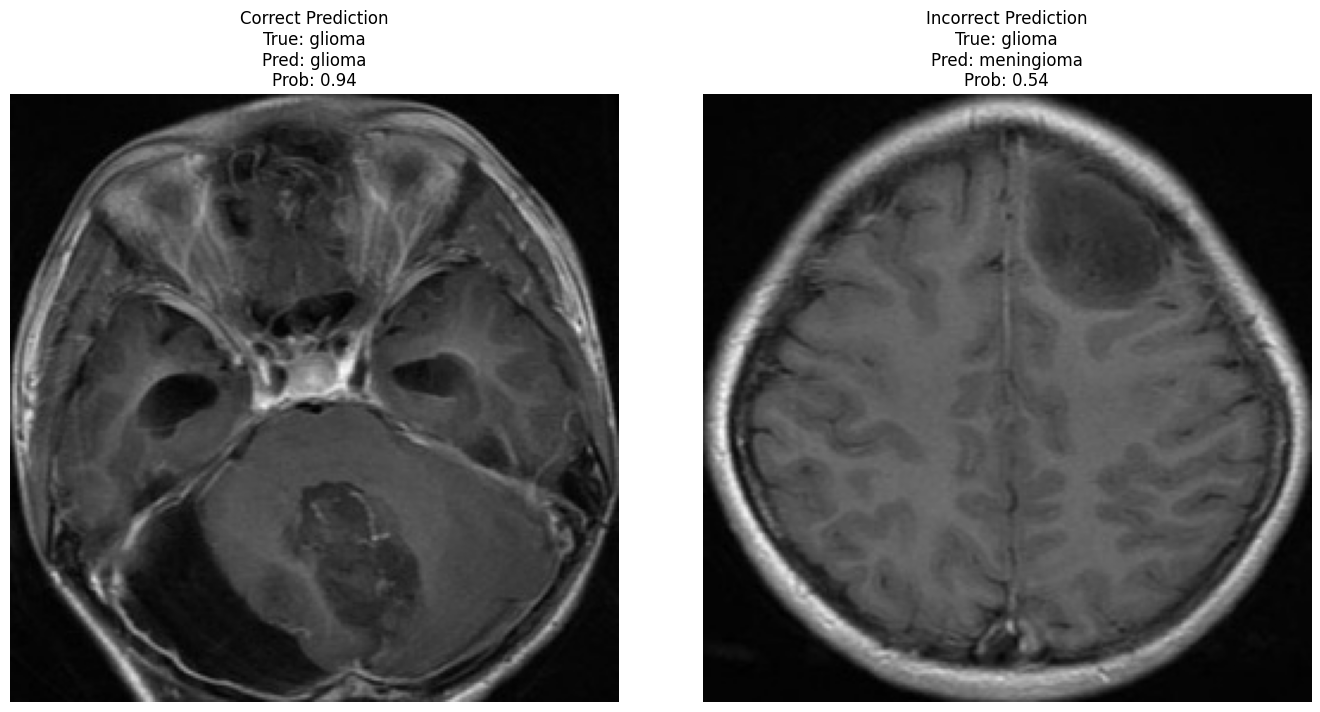

Total Prediction Time: 3.96 seconds
Average Prediction Time per Image: 0.0030 seconds


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import time

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Predict on the test dataset
start_time = time.time()
predictions = model.predict(test_generator)
end_time = time.time()
prediction_time = end_time - start_time

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Find a correct prediction
correct_idx = np.where(predicted_classes == true_classes)[0][0]
correct_image = test_generator[correct_idx][0][0]
correct_true_label = class_labels[true_classes[correct_idx]]
correct_predicted_label = class_labels[predicted_classes[correct_idx]]
correct_probability = predictions[correct_idx, predicted_classes[correct_idx]]

# Find an incorrect prediction
incorrect_idx = np.where(predicted_classes != true_classes)[0][0]
incorrect_image = test_generator[incorrect_idx][0][0]
incorrect_true_label = class_labels[true_classes[incorrect_idx]]
incorrect_predicted_label = class_labels[predicted_classes[incorrect_idx]]
incorrect_probability = predictions[incorrect_idx, predicted_classes[incorrect_idx]]

# Print probability distributions for correct and incorrect predictions
print("Correct Prediction:")
print(f"True Label: {correct_true_label}")
print(f"Predicted Label: {correct_predicted_label}")
print("Class Probabilities:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {predictions[correct_idx, i]:.4f}")
print()

print("Incorrect Prediction:")
print(f"True Label: {incorrect_true_label}")
print(f"Predicted Label: {incorrect_predicted_label}")
print("Class Probabilities:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {predictions[incorrect_idx, i]:.4f}")
print()

# Plot correct and incorrect predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Correct prediction
axes[0].imshow(correct_image)
axes[0].set_title(
    f"Correct Prediction\nTrue: {correct_true_label}\nPred: {correct_predicted_label}\nProb: {correct_probability:.2f}"
)
axes[0].axis('off')

# Incorrect prediction
axes[1].imshow(incorrect_image)
axes[1].set_title(
    f"Incorrect Prediction\nTrue: {incorrect_true_label}\nPred: {incorrect_predicted_label}\nProb: {incorrect_probability:.2f}"
)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print prediction time
print(f"Total Prediction Time: {prediction_time:.2f} seconds")
print(f"Average Prediction Time per Image: {prediction_time / len(test_generator):.4f} seconds")


The prediction time is surprisingly fast. Studying the predictions for a correct and incorrect case, we see that it was very confident in the `glioma` prediction, which was correct. It was uncertain between `glioma` and `meningioma` with respective probabilities of `0.4564` (glioma) and `0.5407` (meningioma). Hence, it looks like the model can have value to an expert, as they can check the probabilities of each class to see the confidence of the model's predictions, and check the ones where it is more uncertain.

The model has even more untapped potential. In particular, just choosing the best parameters from each individual investigation is naive, and will not generally lead to the overall best model. It may be worth to do a randomized grid search over several parameters to find a potentially better model.

## 9. Conclusion

In this document, we explored the use of a convolutional neural network (CNN) for classifying brain tumor images. We reviewed the fundamentals of neural networks, CNNs, and the training process using backpropagation, along with a discussion of the ReLU activation function. Building on this foundation, we used our pre-processing pipeline to investigate key factors influencing performance, including:
- network depth and width,
- batch size,
- learning rate schedules,
- $L^1$ and $L^2$ regularization.

Through this exploration, we gained several valuable insights:
1. Verified the "approximability" of functions by very deep and very wide networks.
2. Analyzed the impact of batch size on training dynamics, particularly on gradient estimation.
3. Drew an interesting parallel between learning rate schedules and annealing processes in metallurgy.
4. Linked the dying ReLU problem with the sparsity induced by $L^1$ regularization, providing a new perspective on its effects.

We have also seen the model in action. We have seen that it can produce accurate predictions confidently. Its less certain predictions also have value to experts, as they can inspect the probabilities to guide their diagnosis. It is therefore a very fruitful practical exercise to check the impact of different parameters on the neural network performance.

We extend this work by considering a modification to the ReLU. In particular, we consider the swish function, which has a non-zero gradient for negative inputs. This is what we will explore in the next section.


# 10. References

[1] **Data Augmentation Techniques in CNN Using TensorFlow**. *Medium*, Medium, [Medium](https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9).

[2] Arena, P., et al. "Image Processing for Medical Diagnosis Using CNN." *Nuclear Instruments and Methods*, Elsevier, 2003.

[3] **Documentation of `ImageDataGenerator` from `Keras`**. TensorFlow, [TensorFlow Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

[4] **Data Augmentation**. IBM, [IBM](https://www.ibm.com/topics/data-augmentation).

[5] **Complete Guide to Data Augmentation**. *DataCamp*, [DataCamp](https://www.datacamp.com/tutorial/complete-guide-data-augmentation).

[6] **Data Augmentation**. Wikipedia, [Wikipedia](https://en.wikipedia.org/wiki/Data_augmentation).

[7] Ramachandran, Prajit, et al. "Searching for Activation Functions." *arXiv*, 16 Oct. 2017, [arXiv](https://arxiv.org/abs/1710.05941).

[8] Glorot, Xavier, et al. "Deep Sparse Rectifier Neural Networks." *AISTATS*, 2011.

[9] Tóth, László. "Phone Recognition with Deep Sparse Rectifier Neural Networks." 2013.

[10] Bhoi, Akash Kumar, et al., editors. *Bio-inspired Neurocomputing*. Vol. 310, Springer, 2021.

[11] Householder, Alston S. "A Theory of Steady-State Activity in Nerve-Fiber Networks: I. Definitions and Preliminary Lemmas." *The Bulletin of Mathematical Biophysics*, vol. 3, no. 2, June 1941, pp. 63–69. [Springer](https://doi.org/10.1007/BF02478220).

[12] Fukushima, K. "Visual Feature Extraction by a Multilayered Network of Analog Threshold Elements." *IEEE Transactions on Systems Science and Cybernetics*, vol. 5, no. 4, 1969, pp. 322–333. [IEEE](https://doi.org/10.1109/TSSC.1969.300225).

[13] **Why Use ReLU?** *Stack Exchange*, [Stack Exchange](https://stats.stackexchange.com/questions/226923/why-do-we-use-relu-in-neural-networks-and-how-do-we-use-it).

[14] **Rectifier (Neural Networks)**. Wikipedia, [Wikipedia](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

[15] Bai, Yuhan. "ReLU-Function and Derived Function Review." *SHS Web of Conferences*, vol. 144, EDP Sciences.

[16] **History of Neural Networks**. Wikipedia, [Wikipedia](https://en.wikipedia.org/wiki/Neural_network).

[17] **Neural Network Lecture Notes**. DST Bristol, [DST Bristol](https://dsbristol.github.io/dst/assets/slides/07.1-PerceptronsNeuralNets.pdf).

[18] **Bias Neuron**. *Stack Overflow*, [Stack Overflow](https://stackoverflow.com/questions/2480650/what-is-the-role-of-the-bias-in-neural-networks).

[19] **Convolutional Neural Network**. Wikipedia, [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network).

[20] **Explained: Neural Networks**. *MIT News*, [MIT News](https://news.mit.edu/2017/explained-neural-networks-deep-learning-0414).

[21] **Tensors in Neural Network Literature: What's the Simplest Definition?** *Stack Exchange*, [Stack Exchange](https://stats.stackexchange.com/questions/233253/tensors-in-neural-network-literature-whats-the-simplest-definition-out-there).

[22] **Tensor Notation to Express Backpropagation**. *DLVU Lecture*, [DLVU](https://dlvu.github.io/slides/dlvu.lecture02.pdf).

[23] van Dyck, Leonard Elia, et al. "Comparing Object Recognition in Humans and Deep Convolutional Neural Networks—An Eye Tracking Study." *Frontiers in Neuroscience*, vol. 15, 2021, pp. 750639. [Frontiers](https://doi.org/10.3389/fnins.2021.750639).

[24] **The Use of CNN for Image Processing**. Svitla, [Svitla](https://svitla.com/blog/cnn-for-image-processing/).

[25] **Interactive Images to Understand CNNs**. *CNN Explainer*, [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

[26] **Understanding the Convolutional Filter Operation in CNNs**. *Medium*, [Medium](https://medium.com/advanced-deep-learning/cnn-operation-with-2-kernels-resulting-in-2-feature-mapsunderstanding-the-convolutional-filter-c4aad26cf32).

[27] **AlexNet**. Wikipedia, [Wikipedia](https://en.wikipedia.org/wiki/AlexNet#:~:text=AlexNet%20is%20the%20name%20of,D).

[28] **CNN | Introduction to Padding**. *GeeksforGeeks*, [GeeksforGeeks](https://www.geeksforgeeks.org/cnn-introduction-to-padding/).

[29] **ReLU Origins**. *Hacker News*, [Hacker News](https://news.ycombinator.com/item?id=13338389).

[30] **What Are the Advantages of ReLU Over Sigmoid Function in Deep Neural Networks?** *Stack Exchange*, [Stack Exchange](https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks).

[31] Robbins, Herbert, and Sutton Monro. "A Stochastic Approximation Method." *The Annals of Mathematical Statistics*, vol. 22, no. 3, 1951, pp. 400-407. [Project Euclid](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-22/issue-3/A-Stochastic-Approximation-Method/10.1214/aoms/1177729586.full).

[32] **Neural Networks: Is an Epoch in SGD the Same as an Epoch in Mini-batch?** *Stack Exchange*, [Stack Exchange](https://stats.stackexchange.com/questions/230120/neural-networks-is-an-epoch-in-sgd-the-same-as-an-epoch-in-mini-batch).

[33] **Introduction to Batch Normalization**. *Analytics Vidhya*, [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/).

[34] Misra, Diganta. "Mish: A Self-Regularized Non-Monotonic Activation Function." *arXiv:1908.08681v1*, 2019. [arXiv](https://arxiv.org/abs/1908.08681).

[35] **Leaky ReLU**. *Papers with Code*, [Papers with Code](https://paperswithcode.com/method/leaky-relu).

[36] **Brain Tumor Dataset**. *Kaggle*, [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

[37] Telgarsky, Matus. "Benefits of Depth in Neural Networks." *Conference on Learning Theory*, 2016. [PMLR](https://proceedings.mlr.press/v49/eldan16.pdf).

[38] **What Graph Neural Networks Cannot Learn: Depth vs Width**. *arXiv*, [arXiv](https://arxiv.org/pdf/1907.03199).

[39] Hazan, Elad, and Tomer Koren. "The Power of Depth for Feedforward Neural Networks." 2016. [MLR](https://proceedings.mlr.press/v49/eldan16.pdf).

[40] van Dijk, Leonard, et al. "How Do Neural Networks See Depth in Single Images?" *ICCV 2019*. [CVF Open Access](https://openaccess.thecvf.com/content_ICCV_2019/papers/van_Dijk_How_Do_Neural_Networks_See_Depth_in_Single_Images_ICCV_2019_paper.pdf).

[41] Goodfellow, Ian, et al. "Improved Techniques for Training GANs." *NeurIPS*, 2016. [NeurIPS](https://proceedings.neurips.cc/paper_files/paper/2019/file/0d1a9651497a38d8b1c3871c84528bd4-Paper.pdf).

[42] **Depth vs Width**. *OpenReview*, [OpenReview](https://openreview.net/pdf?id=B1l2bp4YwS).

[43] **Desmos**. *Desmos*, [Desmos](https://www.desmos.com).

[44] Hornik, Kurt. "Approximation by Superpositions of a Sigmoidal Function." *Neural Networks*, vol. 2, no. 5, 1989, pp. 359-366. [Springer](https://link.springer.com/article/10.1007/BF02551274).

[45] Zhang, Saizheng, et al. "Architectural Complexity Measures of Recurrent Neural Networks." *Advances in Neural Information Processing Systems*, vol. 29, 2016.

[46] Grefenstette, Edward, et al. "On the Turing Completeness of Modern Neural Network Architectures." *arXiv:1901.03429*, 2019. [arXiv](https://arxiv.org/abs/1901.03429).

[47] Nallapati, S. G. R., et al. "Provably Powerful Graph Networks." *arXiv:1905.11136*, 2019. [arXiv](https://arxiv.org/abs/1905.11136).

[48] **Global Average Pooling**. *Papers with Code*, [Papers with Code](https://paperswithcode.com/method/global-average-pooling).

[49] **MobileNet**. *Keras API*, [Keras](https://keras.io/api/applications/mobilenet/#:~:text=This%20is%20known%20as%20the,of%20filters%20in%20each%20layer).

[50] **What is Batch Size in Neural Networks?** *Stack Exchange*, [Stack Exchange](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network).

[51] Goodfellow, Ian, et al. *Deep Learning*. Adaptive Computation and Machine Learning Series. MIT Press, 2016. [Amazon](https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618).

[52] Lee, Jaehoon, et al. "Wide Neural Networks of Any Depth Evolve as Linear Models Under Gradient Descent." *arXiv:1902.06720*, 2019. [arXiv](https://arxiv.org/pdf/1902.06720).

[53] **Understand the Dynamics of Learning Rate on Deep Learning Neural Networks**. *Machine Learning Mastery*, [Machine Learning Mastery](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/).

[54] **What is Annealing?** *TWI Global*, [TWI Global](https://www.twi-global.com/technical-knowledge/faqs/what-is-annealing).

[55] **Understanding Regularization in Neural Networks**. *Zilliz*, [Zilliz](https://zilliz.com/learn/understanding-regularization-in-nueral-networks).

[56] **Regularisation Penalties and Norms**. *Stack Exchange*, [Stack Exchange](https://stats.stackexchange.com/questions/583358/regularisation-penalties-norms).

[57] Hastie, Trevor, et al. *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*. Springer, 2009. [ESL](https://web.stanford.edu/~hastie/ElemStatLearn/).

[58] **Why Use $L^1$ Norm for Sparse Models?** *Stack Exchange*, [Stack Exchange](https://stats.stackexchange.com/questions/45643/why-l1-norm-for-sparse-models).
